<a href="https://colab.research.google.com/github/vicente-gonzalez-ruiz/learned_image_compression/blob/main/notebooks/RateDistortionOptimizedAutoencoder_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
LAMBDA = 10000
EPOCHS = 15

In [2]:
%%bash
# Installs the latest version of TFC compatible with the installed TF version.

read MAJOR MINOR <<< "$(pip show tensorflow | perl -p -0777 -e 's/.*Version: (\d+)\.(\d+).*/\1 \2/sg')"
pip install "tensorflow-compression<$MAJOR.$(($MINOR+1))"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 5.8 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds

In [4]:
training_dataset, validation_dataset = tfds.load(
    "cifar10",
    split=["train[:80%]", "train[80%:]"],
    shuffle_files=True,
    as_supervised=True,
    with_info=False,
)
print(len(training_dataset), len(validation_dataset))

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteH0PCLL/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteH0PCLL/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
40000 10000


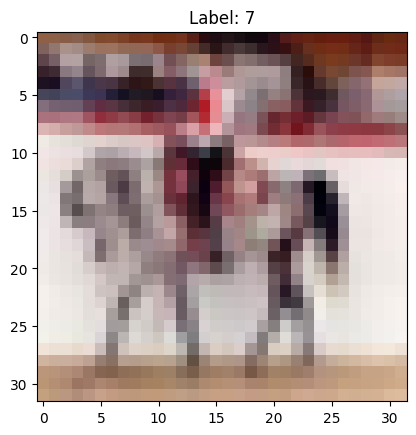

In [5]:
for image, label in training_dataset.take(1):
    # Display the image
    plt.imshow(image)
    plt.title(f"Label: {label.numpy()}")
    plt.show()

In [6]:
PRE_LATENT_SIZE = 2000
LATENT_SIZE = 100

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

LATENT_SIZE = 8*8*50

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
  ], name="analysis_transform")
  return encoder

LATENT_SIZE = 32*32*50

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          20, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          50, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
  ], name="analysis_transform")
  return encoder





In [7]:
def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          3200, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((8, 8, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          51200, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((32, 32, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Reshape((8, 8, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Reshape((32, 32, 50)),
      tf.keras.layers.Conv2DTranspose(
          20, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=1, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder





In [8]:
PRE_LATENT_SIZE = 4096
LATENT_SIZE = 256

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          256, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          256, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          256*8*8, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((8, 8, 256)),
      tf.keras.layers.Conv2DTranspose(
          256, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder

In [9]:
PRE_LATENT_SIZE = 2000
LATENT_SIZE = 100

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          64, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          128, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          128*8*8, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((8, 8, 128)),
      tf.keras.layers.Conv2DTranspose(
          64, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder

In [11]:
PRE_LATENT_SIZE = 4096
LATENT_SIZE = 256

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          128, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          256, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Conv2D(
          512, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_3"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          512*4*4, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((4, 4, 512)),
      tf.keras.layers.Conv2DTranspose(
          256, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          128, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_3"),
  ], name="synthesis_transform")
  return decoder

In [38]:
PRE_LATENT_SIZE = 4096
LATENT_SIZE = 256

def make_analysis_transform(latent_dims=LATENT_SIZE):
  """Creates the analysis (encoder) transform."""
  encoder = tf.keras.Sequential([
      tf.keras.layers.Conv2D(
          128, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(
          256, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")
  return encoder

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  decoder = tf.keras.Sequential([
      tf.keras.layers.Dense(
          PRE_LATENT_SIZE, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(
          256*8*8, use_bias=True, activation="leaky_relu", name="fc_2"),
      tf.keras.layers.Reshape((8, 8, 256)),
      tf.keras.layers.Conv2DTranspose(
          128, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2DTranspose(
          3, 5, use_bias=True, strides=2, padding="same",
          activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")
  return decoder

In [39]:
class CompressionTrainer(tf.keras.Model):
  """Model that trains a compressor/decompressor."""

  def __init__(self, latent_dims=LATENT_SIZE):
    super().__init__()
    self.analysis_transform = make_analysis_transform(latent_dims)
    self.synthesis_transform = make_synthesis_transform()
    self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))

  @property
  def prior(self):
    return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_log_scales))

  def call(self, x, training):
    """Computes rate and distortion losses."""
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    x = tf.reshape(x, (-1, 32, 32, 3))

    # Compute latent space representation y, perturb it and model its entropy,
    # then compute the reconstructed pixel-level representation x_hat.
    y = self.analysis_transform(x)
    entropy_model = tfc.ContinuousBatchedEntropyModel(
        self.prior, coding_rank=1, compression=False)
    y_tilde, rate = entropy_model(y, training=training)
    x_tilde = self.synthesis_transform(y_tilde)

    # Average number of bits per image.
    rate = tf.reduce_mean(rate)

    # Divide rate by the number of neurons in the latent space. This normalizes the rate in bits/neuron.
    rate /= tf.cast(tf.shape(y)[1], dtype=tf.float32)

    # Mean absolute difference across pixels.
    #distortion = tf.reduce_mean(abs(x - x_tilde))
    distortion = tf.sqrt(tf.reduce_mean((x - x_tilde)*(x - x_tilde))) # RMSE
    #distortion = tf.reduce_mean((x - x_tilde)*(x - x_tilde))
    #tf.print(rate, distortion)

    return dict(rate=rate, distortion=distortion)

In [40]:
def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x

def make_compression_trainer(lmbda, latent_dims=LATENT_SIZE):
  trainer = CompressionTrainer(latent_dims)
  trainer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    # Just pass through rate and distortion as losses/metrics.
    loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
    metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
    loss_weights=dict(rate=1., distortion=lmbda),
  )
  return trainer

In [41]:
def add_rd_targets(image, label):
  # Training is unsupervised, so labels aren't necessary here. However, we
  # need to add "dummy" targets for rate and distortion.
  return image, dict(rate=0., distortion=0.)

def train_model(lmbda=LAMBDA, epochs=EPOCHS):
  trainer = make_compression_trainer(lmbda)
  trainer.fit(
      training_dataset.map(add_rd_targets).batch(128).prefetch(8),
      epochs=epochs,
      validation_data=validation_dataset.map(add_rd_targets).batch(128).cache(),
      validation_freq=1,
      verbose=1,
  )
  return trainer

trainer = train_model(lmbda=LAMBDA)
trainer.analysis_transform.summary()
trainer.synthesis_transform.summary()

Epoch 1/15
313/313 [==============================] - ETA: 0s - loss: 2304.3569 - distortion_loss: 0.2302 - rate_loss: 2.3726 - distortion_pass_through_loss: 0.2301 - rate_pass_through_loss: 2.3725

313/313 [==============================] - 32s 93ms/step - loss: 2304.3569 - distortion_loss: 0.2302 - rate_loss: 2.3726 - distortion_pass_through_loss: 0.2301 - rate_pass_through_loss: 2.3725 - val_loss: 1476.0240 - val_distortion_loss: 0.1474 - val_rate_loss: 2.3662 - val_distortion_pass_through_loss: 0.1474 - val_rate_pass_through_loss: 2.3670
Epoch 2/15
313/313 [==============================] - 30s 94ms/step - loss: 1366.7379 - distortion_loss: 0.1364 - rate_loss: 2.4306 - distortion_pass_through_loss: 0.1364 - rate_pass_through_loss: 2.4310 - val_loss: 1232.6685 - val_distortion_loss: 0.1230 - val_rate_loss: 2.5891 - val_distortion_pass_through_loss: 0.1230 - val_rate_pass_through_loss: 2.5905
Epoch 3/15
313/313 [==============================] - 28s 90ms/step - loss: 1198.1375 - distortion_loss: 0.1195 - rate_loss: 2.6529 - distortion_pass_through_loss: 0.1195 - rate_pass_through_loss: 2.6532 - val_loss: 1075.0148 - val_distortion_loss: 0.1072 - val_rate_loss: 2.6891 - val_disto

In [42]:
class Compressor(tf.keras.Model):
  """Compresses images to strings."""

  def __init__(self, analysis_transform, entropy_model):
    super().__init__()
    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model

  def call(self, x):
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    y = self.analysis_transform(x)
    # Also return the exact information content of each digit.
    _, bits = self.entropy_model(y, training=False)
    return self.entropy_model.compress(y), bits

In [43]:
class Decompressor(tf.keras.Model):
  """Decompresses images from strings."""

  def __init__(self, entropy_model, synthesis_transform):
    super().__init__()
    self.entropy_model = entropy_model
    self.synthesis_transform = synthesis_transform

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, ())
    x_hat = self.synthesis_transform(y_hat)
    # Scale and cast back to 8-bit integer.
    return tf.saturate_cast(tf.round(x_hat * 255.), tf.uint8)

In [44]:
def make_codec(trainer, **kwargs):
  # The entropy model must be created with `compression=True` and the same
  # instance must be shared between compressor and decompressor.
  entropy_model = tfc.ContinuousBatchedEntropyModel(
      trainer.prior, coding_rank=1, compression=True, **kwargs)
  compressor = Compressor(trainer.analysis_transform, entropy_model)
  decompressor = Decompressor(entropy_model, trainer.synthesis_transform)
  return compressor, decompressor

compressor, decompressor = make_codec(trainer)

String representation of first digit in hexadecimal: 0x7da6fb2085afd0cb2e607930af33592582c645801fa36ba29d921499898227dfba8d4e60e7087e3bb1a404e0dddd5853300a9e004508d3d970dfdaa565a756ad667f4919c478b191c9c4b49fea7b9ab93074964c892b71921f1011cf06e78945961e338c6e
Number of bits actually needed to represent it: 807.59


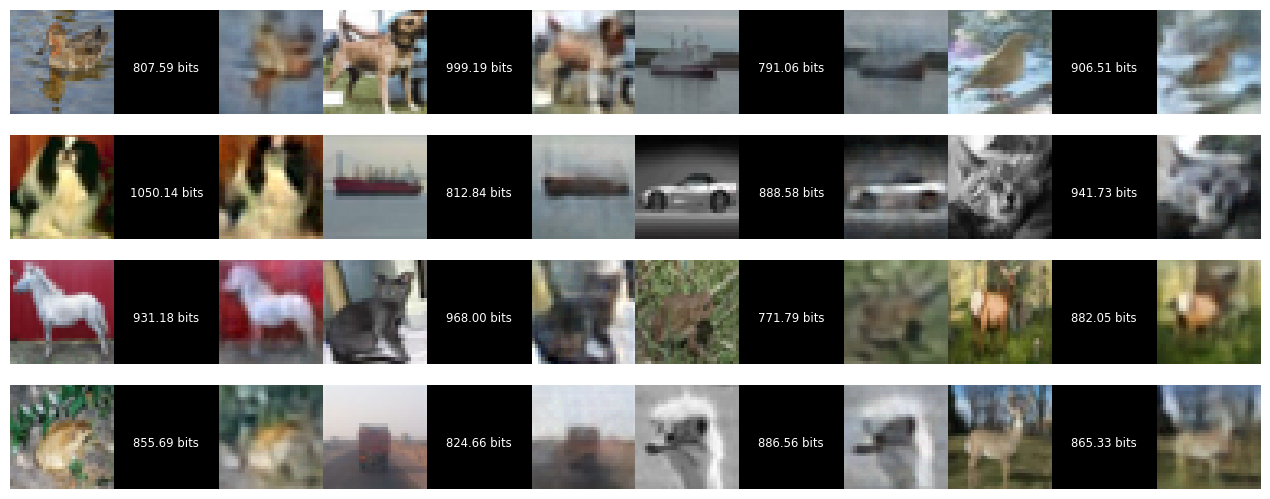

In [45]:
(originals, _), = validation_dataset.batch(16).skip(3).take(1)
strings, entropies = compressor(originals)

print(f"String representation of first digit in hexadecimal: 0x{strings[0].numpy().hex()}")
print(f"Number of bits actually needed to represent it: {entropies[0]:0.2f}")

reconstructions = decompressor(strings)

def display_images(originals, strings, entropies, reconstructions):
  """Visualizes 16 digits together with their reconstructions."""
  fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12.5, 5))
  axes = axes.ravel()
  for i in range(len(axes)):
    image = tf.concat([
        tf.squeeze(originals[i]),
        tf.zeros((32, 32, 3), tf.uint8),
        tf.squeeze(reconstructions[i]),
    ], 1)
    axes[i].imshow(image)
    axes[i].text(
        #.5, .5, f"→ 0x{strings[i].numpy().hex()} →\n{entropies[i]:0.2f} bits",
        .5, .5, f"{entropies[i]:0.2f} bits",
        ha="center", va="top", color="white", fontsize="small",
        transform=axes[i].transAxes)
    axes[i].axis("off")
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)

display_images(originals, strings, entropies, reconstructions)


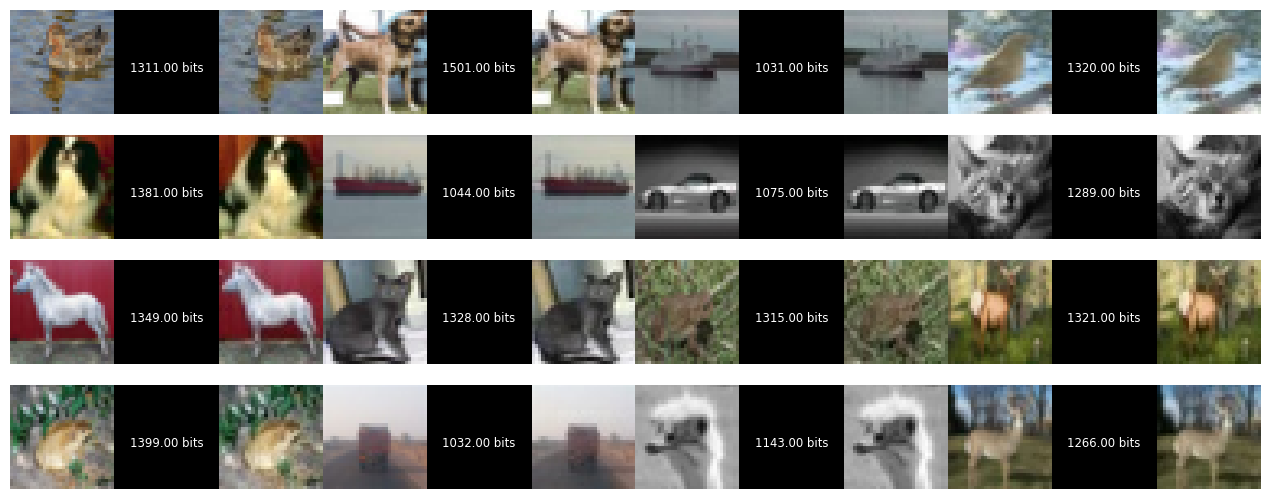

In [19]:
# Compare with JPEG

(originals, _), = validation_dataset.batch(16).skip(3).take(1)

reconstructions = []
entropies = []
for i in originals:
  j = tf.image.encode_jpeg(i)
  k = tf.image.decode_jpeg(j)
  reconstructions.append(k)
  length_j = tf.strings.length(j)
  entropies.append(length_j)

display_images(originals, strings, entropies, reconstructions)